In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("../science.mplstyle")

from sklearn.utils import shuffle


import os


import pickle

from helpers.data_transforms import inverse_transform, clean_data
from helpers.BDT import *
from helpers.physics_functions import *
from helpers.plotting import hist_all_features_array

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"]="0"
import torch
# selecting appropriate device
CUDA = torch.cuda.is_available()
print("cuda available:", CUDA)
device = torch.device("cuda" if CUDA else "cpu")


cuda available: True


In [3]:
import yaml
with open("workflow.yaml", "r") as file:
    workflow = yaml.safe_load(file)
    
    
config_id = "CATHODE_8"

configs_path = f"configs/{config_id}.yml"
with open(configs_path, "r") as file:
    flow_configs = yaml.safe_load(file)
    


Train classifier to discriminate train samples from train data in the SR ONLY
By default, the test set data type is the same as `train_data_id`. There are 2 alternative test sets:
- If the train data is opp sign, one alt test set will be same sign (and vice versa)
- The test set used to construct the ROC curve, which is evaluated on a high-stats dataset

In [7]:
# load in the data

bands = ["SBL", "SR", "SBH"]
data_dict = {}

working_dir = "/global/cfs/cdirs/m3246/rmastand/dimuonAD/projects/logit_08_22/"
#working_dir = "/global/u1/r/rmastand/dimuonAD/projects/powerscaler_0813/"


flow_id = "double_1"
particle_type = "upsilon"
project_id = "lowmass"


train_samples_id = ""
train_data_id = train_samples_id
if train_data_id == "": alt_test_data_id = "_samesign"
elif train_data_id == "_samesign": alt_test_data_id = ""

ROC_test_data_id = ""

with open(f"{working_dir}/models/{project_id}_{particle_type}{train_samples_id}_nojet/{flow_id}/{config_id}/flow_samples", "rb") as infile: 
    train_samples_dict = pickle.load(infile)

# we actually want the "test band" here -- train is just for flow
with open(f"{working_dir}/processed_data/{project_id}_{particle_type}{train_data_id}_nojet_test_band_data", "rb") as infile: 
    train_data_dict = pickle.load(infile)

with open(f"{working_dir}/processed_data/{project_id}_{particle_type}{alt_test_data_id}_nojet_test_band_data", "rb") as infile: 
    alt_test_data_dict = pickle.load(infile)

    
# ROC set is evaluated on the FULL high stats dataset
with open(f"{working_dir}/processed_data/{project_id}_{particle_type}{ROC_test_data_id}_nojet_train_band_data", "rb") as infile: 
    ROC_test_data_dict = pickle.load(infile)

print(f"Loading classifier train samples from {project_id}_{particle_type}{train_samples_id}")
print(f"Loading classifier train data from {project_id}_{particle_type}{train_data_id}")
print(f"Loading alternative test data from {project_id}_{particle_type}{alt_test_data_id}")
print(f"Loading ROC test data from {project_id}_{particle_type}{ROC_test_data_id}")
print()

with open(f"{working_dir}/models/{project_id}_{particle_type}{train_samples_id}_nojet/{flow_id}/{config_id}/configs.txt", "rb") as infile: 
    configs = infile.readlines()[0].decode("utf-8")
    print(configs)



Loading classifier train samples from lowmass_upsilon
Loading classifier train data from lowmass_upsilon
Loading alternative test data from lowmass_upsilon_samesign
Loading ROC test data from lowmass_upsilon

feature_set = ['dimu_pt', 'dimu_eta', 'dimu_mass']



In [8]:
# Assemble the test sets -- consists of both SB and SR

feature_set = ['dimu_pt', 'dimu_eta', 'dimu_mass']


# test set events: not used during flow training
num_events_test_SR = train_data_dict["SR"]["s_inj_data"]["dimu_mass"].shape[0]
test_events_SR = np.empty((num_events_test_SR, len(feature_set)))
num_events_test_SB = train_data_dict["SBH"]["s_inj_data"]["dimu_mass"].shape[0]+train_data_dict["SBL"]["s_inj_data"]["dimu_mass"].shape[0]
test_events_SB = np.empty((num_events_test_SB, len(feature_set)))


# alt test set events
num_events_alt_test = alt_test_data_dict["SR"]["s_inj_data"]["dimu_mass"].shape[0]+alt_test_data_dict["SBH"]["s_inj_data"]["dimu_mass"].shape[0]+alt_test_data_dict["SBL"]["s_inj_data"]["dimu_mass"].shape[0]
alt_test_events = np.empty((num_events_alt_test, len(feature_set)))

# ROC test set events
num_events_ROC = ROC_test_data_dict["SR"]["s_inj_data"]["dimu_mass"].shape[0]+ROC_test_data_dict["SBH"]["s_inj_data"]["dimu_mass"].shape[0]+ROC_test_data_dict["SBL"]["s_inj_data"]["dimu_mass"].shape[0]
ROC_test_events = np.empty((num_events_ROC, len(feature_set)))

for i, feat in enumerate(feature_set):
    
    # default test set
    test_events_SR[:,i] = train_data_dict["SR"]["s_inj_data"][feat].reshape(-1,)
    loc_arr = np.concatenate((train_data_dict["SBL"]["s_inj_data"][feat], train_data_dict["SBH"]["s_inj_data"][feat]))
    test_events_SB[:,i] = loc_arr.reshape(-1,)

    # alt test set
    loc_arr = np.concatenate((alt_test_data_dict["SR"]["s_inj_data"][feat], alt_test_data_dict["SBL"]["s_inj_data"][feat], alt_test_data_dict["SBH"]["s_inj_data"][feat]))
    alt_test_events[:,i] = loc_arr.reshape(-1,)
    
    # ROC test set
    loc_arr = np.concatenate((ROC_test_data_dict["SR"]["s_inj_data"][feat], ROC_test_data_dict["SBL"]["s_inj_data"][feat], ROC_test_data_dict["SBH"]["s_inj_data"][feat]))
    ROC_test_events[:,i] = loc_arr.reshape(-1,)


    
print(f"Total number of default test events: {test_events_SR.shape[0]+test_events_SB.shape[0]}. {test_events_SR.shape[0]} in SR, {test_events_SB.shape[0]} in SB.")
print(f"Total number of alt test events: {num_events_alt_test}")
print(f"Total number of ROC test events: {num_events_ROC}")


SR_min_rescaled = np.min(test_events_SR[:,-1])
SR_max_rescaled = np.max(test_events_SR[:,-1])



Total number of default test events: 34998. 9605 in SR, 25393 in SB.
Total number of alt test events: 34999
Total number of ROC test events: 355570


Training in SR with id: .


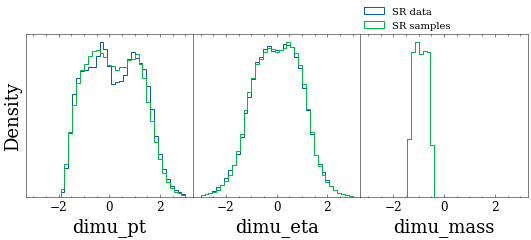

In [9]:
# plot things in the SR

print(f"Training in SR with id: {train_samples_id}.")
hist_all_features_array([train_samples_dict["SR"], train_samples_dict["SR_samples"]], ["SR data", "SR samples"], 
                        feature_set, plot_bound = 3, yscale_log = False)



## Train the BDTs

Train to discriminate (flow samples in SR) from (test data in SR)

In [10]:
import xgboost as xgb

# BDT HYPERPARAMETERS 

n_estimators = 300 # number of boosting stages
max_depth = 5 # max depth of individual regression estimators; related to complexity
learning_rate = 0.1
subsample = 0.7 # fraction of samples to be used for fitting the individual base learners
early_stopping_rounds = 10 # stop training BDT is validation loss doesn't improve after this many rounds



In [11]:
def run_BDT_bump_hunt(flow_samples_SR, data_samples_SR, data_samples_SB, num_folds, num_to_ensemble, 
                      alt_test_sets_data={}, visualize=True):
    
    """
    Classifier is trained only on SR data, to distinguish flow SR samples from SR data
    
    Classifier is evaluated on test data from SR AND SB
    
    Note that alt test sets are NOT split into folds, since we aren't training on them. We do get diff scores for each fold
    """
    
    test_data_splits  = {i:0 for i in range(num_folds)}
    scores_splits = {i:0 for i in range(num_folds)}
    
    # split the alternative test sets
    alt_scores_splits = {}
    alt_data_splits = {}
    for alt_id in alt_test_sets_data.keys():
        alt_scores_splits[alt_id] = {i:0 for i in range(num_folds)}
        # generate a nfold split for the alt test data
        loc_alt_data_split = np.array_split(shuffle(alt_test_sets_data[alt_id]), num_folds) 
        alt_data_splits[alt_id] = {i:loc_alt_data_split[i] for i in range(num_folds)}
        
    # shuffle anything with SB data to mix the low and high masses before splitting 
    flow_samples_SR = shuffle(flow_samples_SR)
    data_samples_SR = shuffle(data_samples_SR)
    data_samples_SB = shuffle(data_samples_SB)
    
    flow_SR_splits = np.array_split(flow_samples_SR, num_folds)
    data_SR_splits = np.array_split(data_samples_SR, num_folds)
    data_SB_splits = np.array_split(data_samples_SB, num_folds) 
    
    for i_fold in range(num_folds):
            
        print(f"Fold {i_fold}:")
        
        """
        ASSEMBLE THE TRAIN / VAL / TEST DATA
        """
        
        # Assemble the train / test data
        training_data, training_labels = [], []
        validation_data, validation_labels = [], []
        testing_data = []

        for ii in range(num_folds):
            
            # test set comprised of SR and SB data
            if ii == i_fold:
                testing_data.append(data_SR_splits[ii])
                testing_data.append(data_SB_splits[ii])
                
            # validation set: flow SR samples, data SR sampkes
            elif ((ii+1)%num_folds) == i_fold:
                validation_data.append(flow_SR_splits[ii])
                validation_labels.append(np.zeros((flow_SR_splits[ii].shape[0],1)))
                validation_data.append(data_SR_splits[ii])
                validation_labels.append(np.ones((data_SR_splits[ii].shape[0],1)))
                
            else:
                training_data.append(flow_SR_splits[ii])
                training_labels.append(np.zeros((flow_SR_splits[ii].shape[0],1)))
                training_data.append(data_SR_splits[ii])
                training_labels.append(np.ones((data_SR_splits[ii].shape[0],1)))
                
        X_train_fold = np.concatenate(training_data)
        Y_train_fold = np.concatenate(training_labels)
        X_val_fold = np.concatenate(validation_data)
        Y_val_fold = np.concatenate(validation_labels)
        
        X_test_fold = np.concatenate(testing_data)
        
        # record the local fold data
        test_data_splits[i_fold] = X_test_fold
     
        """
        SORT THE WEIGHTS OUT
        """
        
        # First do the weights for the regular BC (non-decorr)
        class_weight = {0: 1, 1: sum(Y_train_fold==0)[0]/sum(Y_train_fold==1)[0]}
        class_weights_train = class_weight[0]*(1.0-Y_train_fold)+class_weight[1]*Y_train_fold
        class_weights_val = class_weight[0]*(1.0-Y_val_fold)+class_weight[1]*Y_val_fold
        
        """
        COMBINE W/ DECORRELATED TRAINING
        """
        # we only want to train on the non-mass features

        X_train_fold = X_train_fold[:,:-1]
        X_val_fold = X_val_fold[:,:-1]

        w_train_fold = class_weights_train
        w_val_fold = class_weights_val

        # shuffle for good measure
        X_train_fold, Y_train_fold, w_train_fold = shuffle(X_train_fold, Y_train_fold, w_train_fold)
        X_val_fold, Y_val_fold, w_val_fold = shuffle(X_val_fold, Y_val_fold, w_val_fold)
        
        X_test_fold = X_test_fold[:,:-1]
        
        
        print(f"X train shape: {X_train_fold.shape}, Y train shape: {Y_train_fold.shape}, w train shape: {w_train_fold.shape}.")
        print(f"X val shape: {X_val_fold.shape}, Y val shape: {Y_val_fold.shape}, w val shape: {w_val_fold.shape}.")
        print(f"X test shape: {X_test_fold.shape}." )
        
        """
        INITIALIZE SCORE OBJECTS
        """
        
        scores_fold = np.empty((X_test_fold.shape[0], num_to_ensemble))
        alt_scores_fold = {}
        for alt_id in alt_test_sets_data.keys():
            alt_scores_fold[alt_id] = np.empty((alt_data_splits[alt_id][i_fold].shape[0], num_to_ensemble))
            
   
        """
        TRAIN ENSEMBLE OF TREES
        """
    
        if visualize:
            plt.figure()
        
        for i_tree in range(num_to_ensemble):
            
            print("   Network number:", i_tree)
            random_seed = i_fold*num_to_ensemble + i_tree + 1
                
                
            eval_set = [(X_train_fold, Y_train_fold), (X_val_fold, Y_val_fold)]

            bst_i = xgb.XGBClassifier(n_estimators=n_estimators, max_depth=max_depth, learning_rate=learning_rate, 
                              subsample=subsample,  early_stopping_rounds=early_stopping_rounds,
                              objective='binary:logistic', 
                                      random_state = random_seed, eval_metric="logloss")

            bst_i.fit(X_train_fold, Y_train_fold, sample_weight=w_train_fold, 
                      eval_set=eval_set, sample_weight_eval_set = [w_train_fold, w_val_fold],
                      verbose=False)
            results_f = bst_i.evals_result()
            losses = results_f["validation_0"]["logloss"]
            losses_val = results_f["validation_1"]["logloss"]
            best_epoch = bst_i.best_iteration


            # get scores
            scores_fold[:,i_tree] = bst_i.predict_proba(X_test_fold, iteration_range=(0,bst_i.best_iteration))[:,1]
            for alt_id in alt_test_sets_data.keys():
                alt_scores_fold[alt_id][:,i_tree] = bst_i.predict_proba(alt_data_splits[alt_id][i_fold][:,:-1], iteration_range=(0,bst_i.best_iteration))[:,1]


            
            if visualize:
                
                plt.plot(losses, label = f"{i_tree}", color = f"C{i_tree}")
                plt.plot(losses_val, color = f"C{i_tree}", linestyle = "dashed")
                plt.xlabel("Epochs")
                plt.ylabel("Loss")
                plt.axvline(best_epoch, color = f"C{i_tree}")
                plt.title(f"Fold {i_fold}")
        
        if visualize:
            plt.legend()
            plt.show()
        
            
            
        """
        AVERAGE OVER ENSEMBLE
        """
        
        
            
        #scores_splits[i_fold] = np.mean(scores_fold, axis = 1)
        scores_splits[i_fold] = scores_fold
        for alt_id in alt_test_sets_data.keys():
            #alt_scores_splits[alt_id][i_fold] = np.mean(alt_scores_fold[alt_id], axis = 1)
            alt_scores_splits[alt_id][i_fold] = alt_scores_fold[alt_id]
            
        plt.figure()
        plt.hist2d(test_data_splits[i_fold][:,-1], np.mean(scores_fold, axis = 1), bins = 40, cmap = "hot", density = True)
        plt.xlabel("M (rescaled)")
        plt.ylabel("score")
        #plt.axvline(SR_min_rescaled, color = "red")
        #plt.axvline(SR_max_rescaled, color = "red")
        plt.colorbar()
        plt.colorbar()
        plt.show()
        
        """
        
        plt.figure()
        plt.hist2d(alt_data_splits["FPR_validation"][i_fold][:,-1], np.mean(alt_scores_splits["FPR_validation"][i_fold], axis = 1), bins = 40, cmap = "hot", density = True)
        plt.xlabel("M (rescaled)")
        plt.ylabel("score")
        plt.axvline(SR_min_rescaled, color = "red")
        plt.axvline(SR_max_rescaled, color = "red")
        plt.title("FPR_validation")
        plt.colorbar()
        plt.show()
        
        plt.figure()
        plt.hist2d(alt_data_splits["samesign"][i_fold][:,-1], np.mean(alt_scores_splits["samesign"][i_fold], axis = 1), bins = 40, cmap = "hot", density = True)
        plt.xlabel("M (rescaled)")
        plt.ylabel("score")
        #plt.axvline(SR_min_rescaled, color = "red")
        #plt.axvline(SR_max_rescaled, color = "red")
        plt.title("samesign")
        plt.colorbar()
        plt.show()
        print()
        """
        
    return test_data_splits, scores_splits, alt_data_splits, alt_scores_splits




Fold 0:
X train shape: (64313, 2), Y train shape: (64313, 1), w train shape: (64313, 1).
X val shape: (21437, 2), Y val shape: (21437, 1), w val shape: (21437, 1).
X test shape: (7000, 2).
   Network number: 0
   Network number: 1
   Network number: 2
   Network number: 3
   Network number: 4
   Network number: 5
   Network number: 6
   Network number: 7
   Network number: 8
   Network number: 9


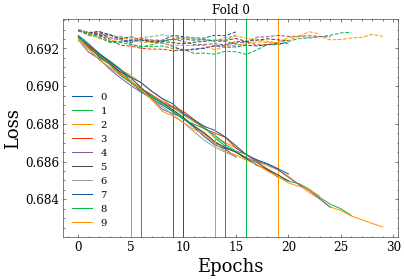

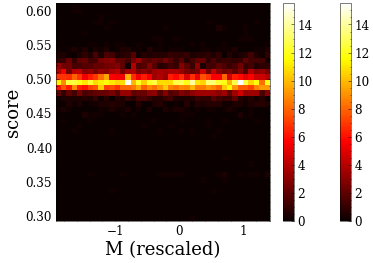

Fold 1:
X train shape: (64312, 2), Y train shape: (64312, 1), w train shape: (64312, 1).
X val shape: (21438, 2), Y val shape: (21438, 1), w val shape: (21438, 1).
X test shape: (7000, 2).
   Network number: 0
   Network number: 1
   Network number: 2
   Network number: 3
   Network number: 4
   Network number: 5
   Network number: 6
   Network number: 7
   Network number: 8
   Network number: 9


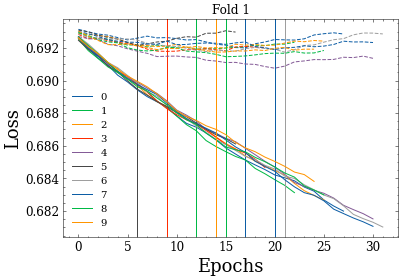

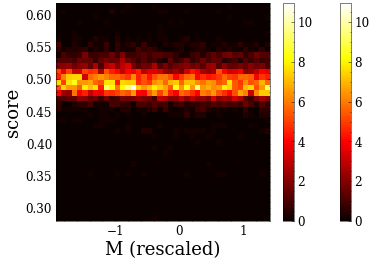

Fold 2:
X train shape: (64312, 2), Y train shape: (64312, 1), w train shape: (64312, 1).
X val shape: (21438, 2), Y val shape: (21438, 1), w val shape: (21438, 1).
X test shape: (7000, 2).
   Network number: 0
   Network number: 1
   Network number: 2
   Network number: 3
   Network number: 4
   Network number: 5
   Network number: 6
   Network number: 7
   Network number: 8
   Network number: 9


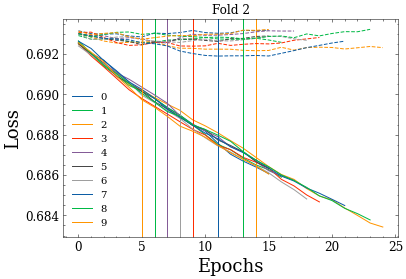

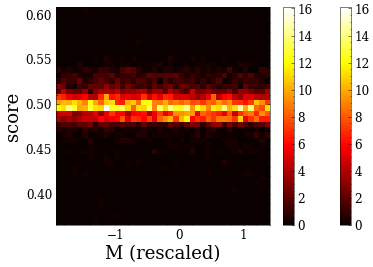

Fold 3:
X train shape: (64313, 2), Y train shape: (64313, 1), w train shape: (64313, 1).
X val shape: (21438, 2), Y val shape: (21438, 1), w val shape: (21438, 1).
X test shape: (6999, 2).
   Network number: 0
   Network number: 1
   Network number: 2
   Network number: 3
   Network number: 4
   Network number: 5
   Network number: 6
   Network number: 7
   Network number: 8
   Network number: 9


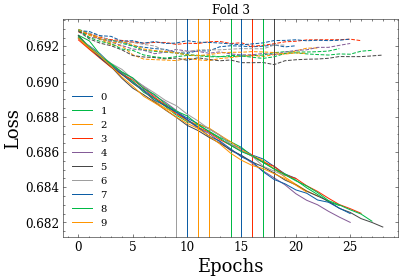

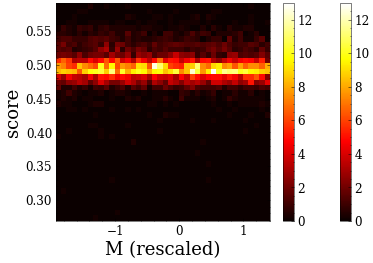

Fold 4:
X train shape: (64314, 2), Y train shape: (64314, 1), w train shape: (64314, 1).
X val shape: (21437, 2), Y val shape: (21437, 1), w val shape: (21437, 1).
X test shape: (6999, 2).
   Network number: 0
   Network number: 1
   Network number: 2
   Network number: 3
   Network number: 4
   Network number: 5
   Network number: 6
   Network number: 7
   Network number: 8
   Network number: 9


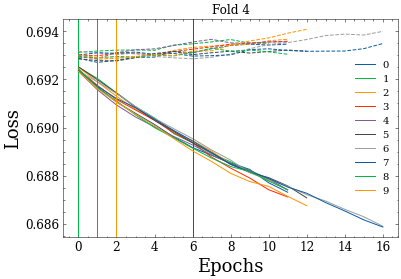

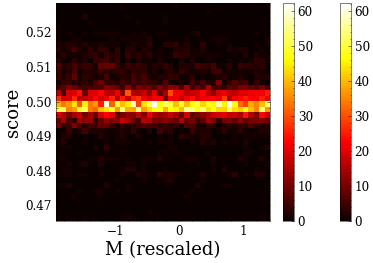

In [12]:
# Train a classifier to discriminate SR samples from SR data

n_folds = 5
n_to_ensemble = 10

alt_test_sets_data = {"FPR_validation":train_samples_dict["SR_samples_validation"],
                      "alt":alt_test_events,
                      "ROC":ROC_test_events}


test_data_splits, scores_splits, alt_data_splits, alt_scores_splits = run_BDT_bump_hunt(clean_data(train_samples_dict["SR_samples"]), 
                                        clean_data(test_events_SR), clean_data(test_events_SB), n_folds, n_to_ensemble, 
                                            alt_test_sets_data=alt_test_sets_data,
                                                                     visualize=True)



## Analysis


### True bump hunt

- Define a polynomial form for the background fit
- For each cut on the classifier score:
  - Fit the background on the cut SB data
  - Estimate N_bkg
  - Calculate S/B, S/sqrt(B)



In [13]:
with open(f"{working_dir}/processed_data/mass_scaler_{particle_type}", "rb") as ifile:
    scaler = pickle.load(ifile)
    
fpr_thresholds = [1, 0.25, 0.1, 0.05, 0.01]
#score_cutoffs = {i:{threshold:np.zeros((n_to_ensemble,1)) for threshold in fpr_thresholds} for i in range(n_folds)}
score_cutoffs = {i:{threshold:0 for threshold in fpr_thresholds} for i in range(n_folds)}


for i_fold in range(n_folds):
    for threshold in fpr_thresholds:
        
        #for i_classifier in range(n_to_ensemble): # may want to do ensembling later?
        
            loc_scores_sorted = np.sort(1.0-np.mean(alt_scores_splits["FPR_validation"][i_fold], axis = 1))
            loc_score_cutoff = 1-loc_scores_sorted[min(int(threshold*len(loc_scores_sorted)),len(loc_scores_sorted)-1)]
            
            score_cutoffs[i_fold][threshold] = loc_score_cutoff


In [21]:
SB_left = float(workflow[particle_type]["SB_left"])
SR_left = float(workflow[particle_type]["SR_left"])
SR_right = float(workflow[particle_type]["SR_right"])
SB_right = float(workflow[particle_type]["SB_right"])
    
TPRs, FPRs = [], []

remove_edge = True



    
    
x = np.linspace(SB_left, SB_right, 100)

# get bins, bin centers
plot_bins_all, plot_bins_SR, plot_bins_left, plot_bins_right, plot_centers_all, plot_centers_SR, plot_centers_SB = get_bins(SR_left, SR_right, SB_left, SB_right, remove_edge)


fit_type = "cubic"
if fit_type == "cubic": fit_function = bkg_fit_cubic
elif fit_type == "quintic": fit_function = bkg_fit_quintic
elif fit_type == "ratio": fit_function = bkg_fit_ratio


plt.figure(figsize = (12, 9))
for t, threshold in enumerate(fpr_thresholds):
    
    # corrections to SR / SB efficiencies
    filtered_masses = []
    
    for i_fold in range(n_folds):
        
        
        loc_true_masses = scaler.inverse_transform(np.array(test_data_splits[i_fold][:,-1]).reshape(-1,1))
        loc_scores = np.mean(scores_splits[i_fold], axis = 1)
        loc_filtered_masses, loc_SBL_eff, loc_SBH_eff, loc_SR_eff = select_top_events_fold(loc_true_masses, loc_scores, score_cutoffs[i_fold][threshold],
                                                                                           plot_bins_left, plot_bins_right, plot_bins_SR)
        

        filtered_masses.append(loc_filtered_masses)

        

    filtered_masses = np.concatenate(filtered_masses)

    
    # get the fit function to SB background
    popt, pcov, chi2, y_vals, n_dof = curve_fit_m_inv(filtered_masses, fit_type, SR_left, SR_right, plot_bins_left, plot_bins_right, plot_centers_all,)
    #print("chi2/dof:", chi2/n_dof)
    # plot the fit function
    plt.plot(plot_centers_all, fit_function(plot_centers_all, *popt), lw = 2, linestyle = "dashed", color = f"C{t}")    
    
    # calculate significance of bump
    num_S_expected_in_SR, num_B_expected_in_SR = calc_significance(filtered_masses, fit_function, plot_bins_SR, SR_left, SR_right, popt)
    
    if threshold == 1:
        S_total, B_total = num_S_expected_in_SR, num_B_expected_in_SR
    
    TPRs.append(num_S_expected_in_SR/S_total)
    FPRs.append(num_B_expected_in_SR/B_total)
        

    y_err = get_errors_bkg_fit_ratio(popt, pcov, plot_centers_SR, fit_type)
    B_error = np.sum(y_err)

    label_string = str(round(100*threshold, 2))+"% FPR: $S/B$: "+str(round(num_S_expected_in_SR/num_B_expected_in_SR,2))+", $S/\sqrt{B}$: "+str(round(num_S_expected_in_SR/np.sqrt(num_B_expected_in_SR+B_error**2),2))

    plt.hist(filtered_masses, bins = plot_bins_all, lw = 3, histtype = "step", color = f"C{t}",label = label_string)
    plt.scatter(plot_centers_SB, y_vals, color = f"C{t}")
    
    

print() 
plt.legend(loc = (1, 0), fontsize = 24)


plt.axvline(SR_left, color= "k", lw = 3, zorder = -10)
plt.axvline(SR_right, color= "k", lw = 3, zorder = -10)

plt.xlabel("$M_{\mu\mu}$ [GeV]", fontsize = 24)
plt.ylabel("Counts", fontsize = 24)


plt.title(f"{particle_type}{train_data_id} (trained on {train_data_id})\n"+"  ".join(feature_set[:-1])+"\n", fontsize = 24)



IndexError: boolean index did not match indexed array along dimension 0; dimension is 7000 but corresponding boolean dimension is 10

<Figure size 864x648 with 0 Axes>





Repeat for alternative test set

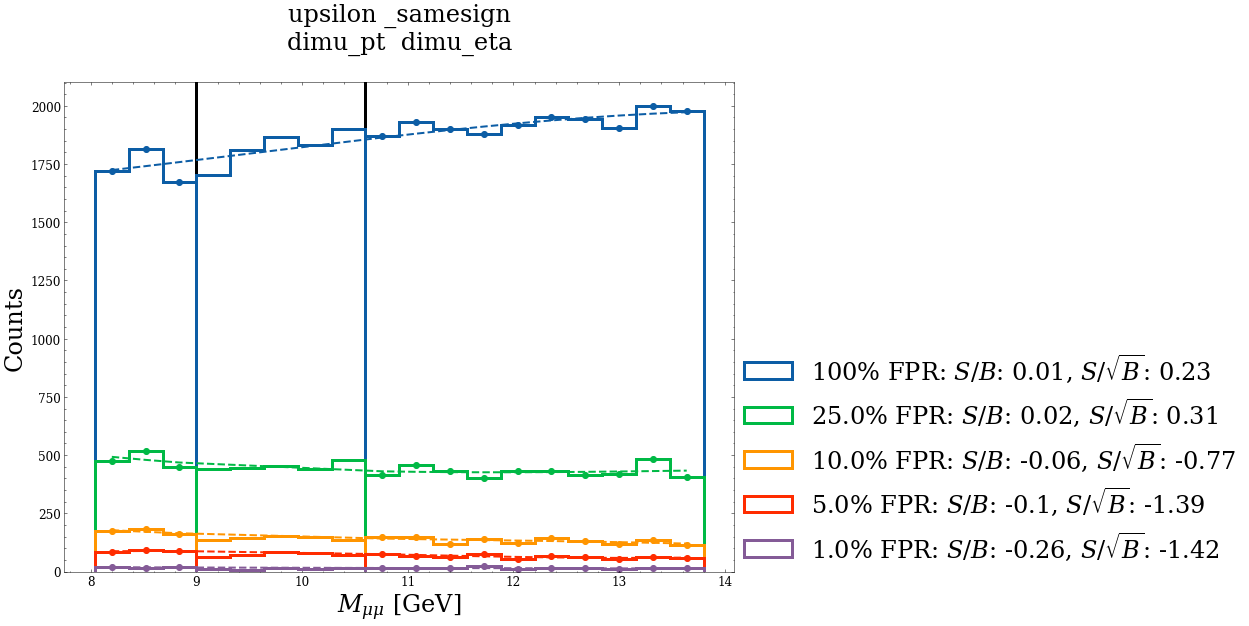

In [15]:
fit_type = "cubic"
if fit_type == "cubic": fit_function = bkg_fit_cubic
elif fit_type == "quintic": fit_function = bkg_fit_quintic
elif fit_type == "ratio": fit_function = bkg_fit_ratio



plt.figure(figsize = (12, 9))
for t, threshold in enumerate(fpr_thresholds):
    
    # corrections to SR / SB efficiencies
    filtered_masses = []
    
    for i_fold in range(n_folds):
        
        
        
        
        loc_true_masses = scaler.inverse_transform(alt_data_splits["alt"][i_fold][:,-1].reshape(-1,1))
        loc_scores = np.mean(alt_scores_splits["alt"][i_fold], axis = 1)
        loc_filtered_masses, loc_SBL_eff, loc_SBH_eff, loc_SR_eff = select_top_events_fold(loc_true_masses, loc_scores, score_cutoffs[i_fold][threshold],
                                                                                           plot_bins_left, plot_bins_right, plot_bins_SR)
        
        filtered_masses.append(loc_filtered_masses)

        
    filtered_masses = np.concatenate(filtered_masses)

    
    # get the fit function to SB background
    popt, pcov, chi2, y_vals, n_dof = curve_fit_m_inv(filtered_masses, fit_type, SR_left, SR_right, plot_bins_left, plot_bins_right, plot_centers_all)
    #print("chi2/dof:", chi2/n_dof)
    # plot the fit function
    plt.plot(plot_centers_all, fit_function(plot_centers_all, *popt), lw = 2, linestyle = "dashed", color = f"C{t}")    
    
    # calculate significance of bump
    num_S_expected_in_SR, num_B_expected_in_SR = calc_significance(filtered_masses, fit_function, plot_bins_SR, SR_left, SR_right, popt)
    #print(num_S_expected_in_SR, num_B_expected_in_SR)

    y_err = get_errors_bkg_fit_ratio(popt, pcov, plot_centers_SR, fit_type)
    B_error = np.sum(y_err)

    label_string = str(round(100*threshold, 2))+"% FPR: $S/B$: "+str(round(num_S_expected_in_SR/num_B_expected_in_SR,2))+", $S/\sqrt{B}$: "+str(round(num_S_expected_in_SR/np.sqrt(num_B_expected_in_SR+B_error**2),2))

    plt.hist(filtered_masses, bins = plot_bins_all, lw = 3, histtype = "step", color = f"C{t}",label = label_string)
    plt.scatter(plot_centers_SB, y_vals, color = f"C{t}")
    
    
    
    
#plt.title(",  ".join(feature_set[:-1])+"\n", fontsize = 18) 
plt.legend(loc = (1, 0), fontsize = 24)
#plt.yscale("log")

plt.axvline(SR_left, color= "k", lw = 3, zorder = -10)
plt.axvline(SR_right, color= "k", lw = 3, zorder = -10)

plt.xlabel("$M_{\mu\mu}$ [GeV]", fontsize = 24)
plt.ylabel("Counts", fontsize = 24)



plt.title(f"{particle_type}{alt_test_data_id} (trained on {train_data_id})\n"+"  ".join(feature_set[:-1])+"\n", fontsize = 24)

plt.show()

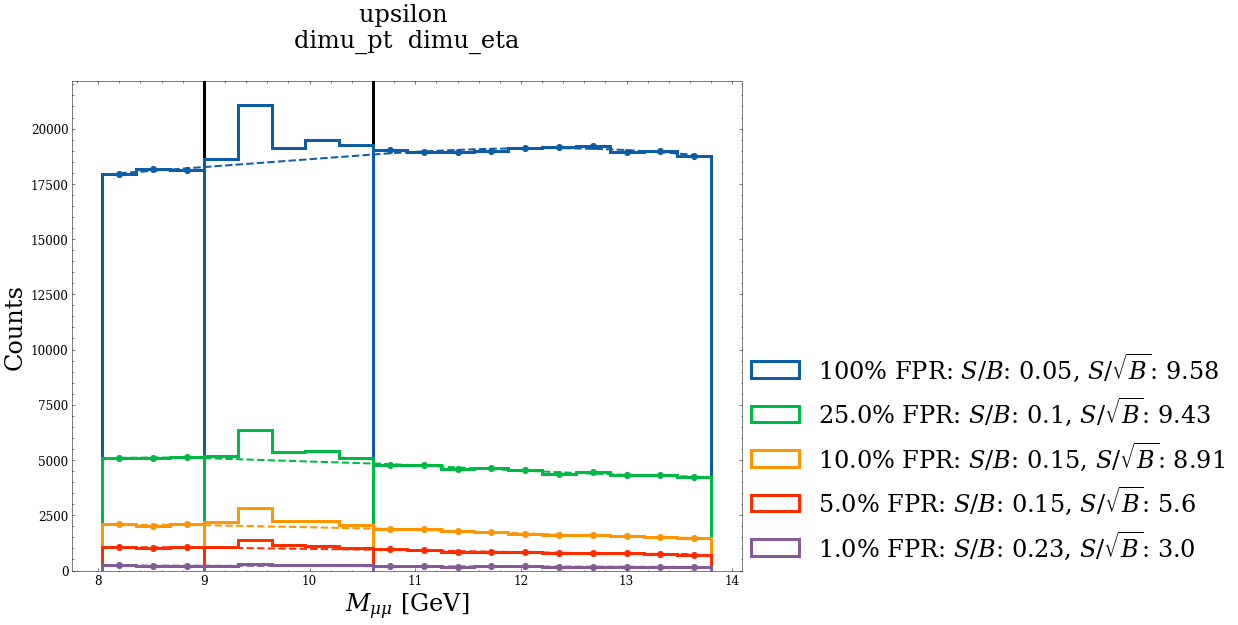

In [16]:
SB_left = float(workflow[particle_type]["SB_left"])
SR_left = float(workflow[particle_type]["SR_left"])
SR_right = float(workflow[particle_type]["SR_right"])
SB_right = float(workflow[particle_type]["SB_right"])
    
TPRs, FPRs = [], []

remove_edge = True


    
    
x = np.linspace(SB_left, SB_right, 100)

# get bins, bin centers
plot_bins_all, plot_bins_SR, plot_bins_left, plot_bins_right, plot_centers_all, plot_centers_SR, plot_centers_SB = get_bins(SR_left, SR_right, SB_left, SB_right, remove_edge)


fit_type = "cubic"
if fit_type == "cubic": fit_function = bkg_fit_cubic
elif fit_type == "quintic": fit_function = bkg_fit_quintic
elif fit_type == "ratio": fit_function = bkg_fit_ratio


plt.figure(figsize = (12, 9))
for t, threshold in enumerate(fpr_thresholds):
    
    # corrections to SR / SB efficiencies
    filtered_masses = []
    
    for i_fold in range(n_folds):
        
        
        loc_true_masses = scaler.inverse_transform(np.array(alt_data_splits["ROC"][i_fold][:,-1]).reshape(-1,1))
        loc_scores = np.mean(alt_scores_splits["ROC"][i_fold], axis = 1)
        loc_filtered_masses, loc_SBL_eff, loc_SBH_eff, loc_SR_eff = select_top_events_fold(loc_true_masses, loc_scores, score_cutoffs[i_fold][threshold],
                                                                                           plot_bins_left, plot_bins_right, plot_bins_SR)
        

        filtered_masses.append(loc_filtered_masses)

        

    filtered_masses = np.concatenate(filtered_masses)

    
    # get the fit function to SB background
    popt, pcov, chi2, y_vals, n_dof = curve_fit_m_inv(filtered_masses, fit_type, SR_left, SR_right, plot_bins_left, plot_bins_right, plot_centers_all,)
    #print("chi2/dof:", chi2/n_dof)
    # plot the fit function
    plt.plot(plot_centers_all, fit_function(plot_centers_all, *popt), lw = 2, linestyle = "dashed", color = f"C{t}")    
    
    # calculate significance of bump
    num_S_expected_in_SR, num_B_expected_in_SR = calc_significance(filtered_masses, fit_function, plot_bins_SR, SR_left, SR_right, popt)


    y_err = get_errors_bkg_fit_ratio(popt, pcov, plot_centers_SR, fit_type)
    B_error = np.sum(y_err)

    label_string = str(round(100*threshold, 2))+"% FPR: $S/B$: "+str(round(num_S_expected_in_SR/num_B_expected_in_SR,2))+", $S/\sqrt{B}$: "+str(round(num_S_expected_in_SR/np.sqrt(num_B_expected_in_SR+B_error**2),2))

    plt.hist(filtered_masses, bins = plot_bins_all, lw = 3, histtype = "step", color = f"C{t}",label = label_string)
    plt.scatter(plot_centers_SB, y_vals, color = f"C{t}")
    
    

print() 
plt.legend(loc = (1, 0), fontsize = 24)


plt.axvline(SR_left, color= "k", lw = 3, zorder = -10)
plt.axvline(SR_right, color= "k", lw = 3, zorder = -10)

plt.xlabel("$M_{\mu\mu}$ [GeV]", fontsize = 24)
plt.ylabel("Counts", fontsize = 24)
plt.title(f"{particle_type} {ROC_test_data_id} (trained on {train_data_id})\n"+"  ".join(feature_set[:-1])+"\n", fontsize = 24)
plt.show()


## ROC curve


### Bootstrapping

In [17]:
"""
    
TPRs, FPRs = [], []

remove_edge = True



fit_type = "cubic"
if fit_type == "cubic": fit_function = bkg_fit_cubic
elif fit_type == "quintic": fit_function = bkg_fit_quintic
elif fit_type == "ratio": fit_function = bkg_fit_ratio



fpr_thresholds = np.logspace(0, -3, 20)
#fpr_thresholds = np.linspace(1, 0 , 50)



# first determine score cutoffs, which are the same across all bootstraps
score_cutoffs = {threshold:{} for threshold in fpr_thresholds}
for t, threshold in enumerate(fpr_thresholds):
    for i_fold in range(n_folds):
        loc_scores_sorted = np.sort(1.0-alt_scores_splits["FPR_validation"][i_fold])
        score_cutoffs[threshold][i_fold] = 1-loc_scores_sorted[min(int(threshold*len(loc_scores_sorted)),len(loc_scores_sorted)-1)]
        




num_boostraps = 50

S_yield, B_yield = np.empty((fpr_thresholds.shape[0], num_boostraps)), np.empty((fpr_thresholds.shape[0], num_boostraps))

for bs in range(num_boostraps):
    
    print(f"On bootstrap {bs}...")
    
    # determine the indices that we take for each fold
    # they should be the same for all thresholds so that we can account for correlations across classifier cuts
    bs_indices_per_fold = {i_fold:np.random.choice(range(alt_data_splits["ROC"][i_fold].shape[0]), size = alt_data_splits["ROC"][i_fold].shape[0]) for i_fold in range(n_folds)}

    for t, threshold in enumerate(fpr_thresholds):
    
        filtered_masses_bs = []
    
        for i_fold in range(n_folds):

            # get boostrapped masses and scores
            loc_true_masses_bs = scaler.inverse_transform(np.array(alt_data_splits["ROC"][i_fold][:,-1]).reshape(-1,1))[bs_indices_per_fold[i_fold]]
            loc_scores_bs = alt_scores_splits["ROC"][i_fold][bs_indices_per_fold[i_fold]]
            # filter top event based on score cutoff
            loc_filtered_masses_bs, _, _, _ = select_top_events_fold(loc_true_masses_bs, loc_scores_bs, score_cutoffs[threshold][i_fold], plot_bins_left, plot_bins_right, plot_bins_SR)
            filtered_masses_bs.append(loc_filtered_masses_bs)

        filtered_masses_bs = np.concatenate(filtered_masses_bs)

        # get the fit function to SB background
        popt, pcov, chi2, y_vals, n_dof = curve_fit_m_inv(filtered_masses_bs, fit_type, SR_left, SR_right, plot_bins_left, plot_bins_right, plot_centers_all)
        num_S_expected_in_SR, num_B_expected_in_SR = calc_significance(filtered_masses_bs, fit_function, plot_bins_SR, SR_left, SR_right, popt)
        
        S_yield[t, bs] = num_S_expected_in_SR
        B_yield[t, bs] =num_B_expected_in_SR


"""     
        


'\n    \nTPRs, FPRs = [], []\n\nremove_edge = True\n\n\n\nfit_type = "cubic"\nif fit_type == "cubic": fit_function = bkg_fit_cubic\nelif fit_type == "quintic": fit_function = bkg_fit_quintic\nelif fit_type == "ratio": fit_function = bkg_fit_ratio\n\n\n\nfpr_thresholds = np.logspace(0, -3, 20)\n#fpr_thresholds = np.linspace(1, 0 , 50)\n\n\n\n# first determine score cutoffs, which are the same across all bootstraps\nscore_cutoffs = {threshold:{} for threshold in fpr_thresholds}\nfor t, threshold in enumerate(fpr_thresholds):\n    for i_fold in range(n_folds):\n        loc_scores_sorted = np.sort(1.0-alt_scores_splits["FPR_validation"][i_fold])\n        score_cutoffs[threshold][i_fold] = 1-loc_scores_sorted[min(int(threshold*len(loc_scores_sorted)),len(loc_scores_sorted)-1)]\n        \n\n\n\n\nnum_boostraps = 50\n\nS_yield, B_yield = np.empty((fpr_thresholds.shape[0], num_boostraps)), np.empty((fpr_thresholds.shape[0], num_boostraps))\n\nfor bs in range(num_boostraps):\n    \n    print(f"

### True classifier uncertainty

In [18]:

    
TPRs, FPRs = [], []

remove_edge = True



fit_type = "cubic"
if fit_type == "cubic": fit_function = bkg_fit_cubic
elif fit_type == "quintic": fit_function = bkg_fit_quintic
elif fit_type == "ratio": fit_function = bkg_fit_ratio



fpr_thresholds = np.logspace(0, -3, 50)
#fpr_thresholds = np.linspace(1, 0 , 50)



# first determine score cutoffs
score_cutoffs = {i:{threshold:np.zeros((n_to_ensemble,1)) for threshold in fpr_thresholds} for i in range(n_folds)}

for t, threshold in enumerate(fpr_thresholds):
    for i_fold in range(n_folds):
        for i_classifier in range(n_to_ensemble):
            loc_scores_sorted = np.sort(1.0-alt_scores_splits["FPR_validation"][i_fold][:,i_classifier])
            score_cutoffs[i_fold][threshold][i_classifier] = 1-loc_scores_sorted[min(int(threshold*len(loc_scores_sorted)),len(loc_scores_sorted)-1)]
        

        

S_yield, B_yield = np.empty((fpr_thresholds.shape[0], n_to_ensemble)), np.empty((fpr_thresholds.shape[0], n_to_ensemble))

for bs in range(n_to_ensemble):
    
    print(f"On classifier index {bs}...")

    for t, threshold in enumerate(fpr_thresholds):
    
        filtered_masses_bs = []
    
        for i_fold in range(n_folds):

            loc_true_masses_bs = scaler.inverse_transform(np.array(alt_data_splits["ROC"][i_fold][:,-1]).reshape(-1,1))
            loc_scores_bs = alt_scores_splits["ROC"][i_fold][:,bs]
            # filter top event based on score cutoff
            loc_filtered_masses_bs, _, _, _ = select_top_events_fold(loc_true_masses_bs, loc_scores_bs, score_cutoffs[i_fold][threshold][bs], plot_bins_left, plot_bins_right, plot_bins_SR)
            filtered_masses_bs.append(loc_filtered_masses_bs)

        filtered_masses_bs = np.concatenate(filtered_masses_bs)

        # get the fit function to SB background
        popt, pcov, chi2, y_vals, n_dof = curve_fit_m_inv(filtered_masses_bs, fit_type, SR_left, SR_right, plot_bins_left, plot_bins_right, plot_centers_all)
        num_S_expected_in_SR, num_B_expected_in_SR = calc_significance(filtered_masses_bs, fit_function, plot_bins_SR, SR_left, SR_right, popt)
        
        S_yield[t, bs] = num_S_expected_in_SR
        B_yield[t, bs] = num_B_expected_in_SR


        
        


On classifier index 0...
On classifier index 1...
On classifier index 2...
On classifier index 3...
On classifier index 4...
On classifier index 5...
On classifier index 6...
On classifier index 7...
On classifier index 8...
On classifier index 9...


In [19]:



# calculate summary stats
TPR = S_yield/S_yield[0,:]
FPR = B_yield/B_yield[0,:]

ROC = 1.0/FPR

SIC = TPR/np.sqrt(FPR)


def get_median_percentiles(x_array):
    
    
    x_median = np.median(x_array, axis = 1)
    x_lower = np.percentile(x_array, 16, axis = 1)
    x_upper = np.percentile(x_array, 84, axis = 1)

    return x_median, x_lower, x_upper


Classifier trained on ['dimu_pt', 'dimu_eta']


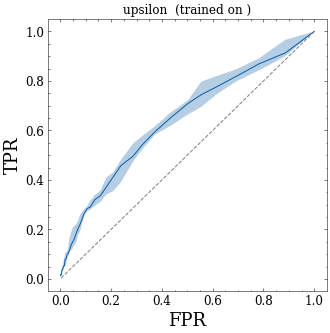

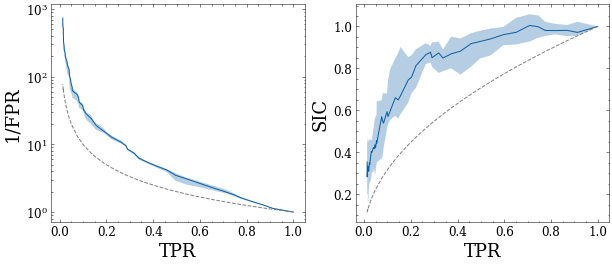

In [22]:
TPR_median, TPR_lower, TPR_upper = get_median_percentiles(TPR)
FPR_median, FPR_lower, FPR_upper = get_median_percentiles(FPR)
ROC_median, ROC_lower, ROC_upper = get_median_percentiles(ROC)
SIC_median, SIC_lower, SIC_upper = get_median_percentiles(SIC)

print(f"Classifier trained on {feature_set[:-1]}")

plt.figure(figsize = (5, 5))



plt.plot(FPR_median, TPR_median)
plt.fill_between(FPR_median, TPR_lower, TPR_upper, alpha = 0.3 )

plt.plot(FPR_median, FPR_median, linestyle = "dashed", color = "grey")
plt.xlabel("FPR")
plt.ylabel("TPR")


plt.title(f"{particle_type} {ROC_test_data_id} (trained on {train_data_id})")


fig, ax = plt.subplots(1, 2, figsize = (10, 4))


ax[0].plot(TPR_median, ROC_median)
ax[0].fill_between(TPR_median, ROC_lower, ROC_upper, alpha = 0.3 )
ax[0].plot(TPR_median, 1.0/TPR_median, linestyle = "dashed", color = "grey")
ax[0].set_xlabel("TPR")
ax[0].set_ylabel("1/FPR")
ax[0].set_yscale("log")


    
ax[1].plot(TPR_median, SIC_median)
ax[1].fill_between(TPR_median, SIC_lower, SIC_upper, alpha = 0.3 )
ax[1].plot(TPR_median, TPR_median/np.sqrt(TPR_median), linestyle = "dashed", color = "grey")
ax[1].set_xlabel("TPR")
ax[1].set_ylabel("SIC")


plt.show()